# Compare ROMS outputs to GOES SST estimates

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import numpy as np
import cmocean.cm as cmo
import time
import datetime
import glob
import pandas as pd
import xesmf as xe
import dask
import os
import calendar
from matplotlib import gridspec

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader
import cartopy.io.img_tiles as cimgt

### Load in GOES Satellite Data

In [ ]:
sat_21staxi = np.load('2021_timeseries_tindex.npy')
sat_21stser = np.load('2021_timeseries_satdata.npy')
sat_22staxi = np.load('2022_timeseries_tindex.npy')
sat_22stser = np.load('2022_timeseries_satdata.npy')

### Load in Reanalysis Data

In [ ]:
era5_sst = np.load('ERA5_SST_TimeSeries.npy')
era5_taxi = np.load('ERA5_SST_Taxi.npy')

### Load in ROMS Outputs

In [7]:
rroot = '/qfs/people/hins978/Notebooks/OCCAMS_ROMS/GOES_SST/Figures/'

# Surface maps
pmap_21 = np.load('2021_plotmaps.npy')
pmap_22 = np.load('2022_plotmaps.npy')
# Time Series
roms_21mtser = np.load('2021_timeseries_roms.npy')
roms_22mtser = np.load('2022_timeseries_roms.npy')

### Load in COAWST Outputs

In [8]:
# maps and time series

cwst_map = np.load('coawst_2107_2206_plotmaps.npy')
cwst_mtaxi = np.load('coawst2122_timeseries_Taxi.npy')
cwst_mtser = np.load('coawst2122_timeseries_data.npy')

#### Generate common time series and plot results

In [11]:
mtaxi = pd.date_range('2020-11-01','2023-02-01', freq='ME') #  periods=25
ddel = datetime.timedelta(days=15)

Text(0, 0.5, 'Sea Surface Temperature, $^\\circ$C')

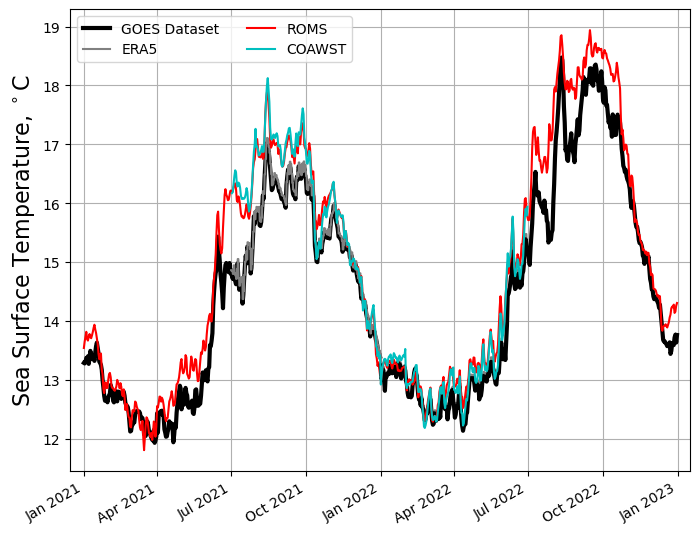

In [18]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.plot(sat_21staxi, sat_21stser, color='k', label='GOES Dataset', linewidth=3)
ax.plot(era5_taxi, era5_sst, color='grey', label='ERA5')

ax.plot(sat_21staxi, roms_21mtser, color='r', label='ROMS')
ax.plot(sat_22staxi, sat_22stser, color='k', linewidth=3)
ax.plot(sat_22staxi, roms_22mtser, color='r')
ax.plot(cwst_mtaxi, cwst_mtser, color='c', label='COAWST')

# Set major ticks to be at the start of each month
ax.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

# Format major tick labels to show month and year
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
# Optional: set minor ticks for days
ax.grid()
ax.set_xlim([mtaxi[0]+ddel, mtaxi[-1]-ddel])
ax.legend(ncols=2)
ax.set_ylabel('Sea Surface Temperature, $^\circ$C', fontsize=16)

## Make Seasonal Maps

In [19]:
longrab = np.array([-127.  , -126.75, -126.5 , -126.25, -126.  , -125.75, -125.5 ,
       -125.25, -125.  , -124.75, -124.5 , -124.25, -124.  , -123.75,
       -123.5 , -123.25, -123.  , -122.75, -122.5 , -122.25, -122.  ,
       -121.75, -121.5 , -121.25, -121.  ])

latgrab = np.array([42.  , 41.75, 41.5 , 41.25, 41.  , 40.75, 40.5 , 40.25, 40.  ,
       39.75, 39.5 , 39.25, 39.  , 38.75, 38.5 , 38.25, 38.  , 37.75,
       37.5 , 37.25, 37.  , 36.75, 36.5 , 36.25, 36.  , 35.75, 35.5 ,
       35.25, 35.  , 34.75, 34.5 , 34.25, 34.  , 33.75, 33.5 , 33.25,
       33.  , 32.75, 32.5 , 32.25, 32.  ])

lonticks = longrab[0::8]
latticks = latgrab[0::4]

In [21]:
rmaps_all = np.concatenate((pmap_21, pmap_22), axis=0)
rmaps_all.shape

(24, 41, 25)

In [23]:
szn_lab = ['Summer', 'Fall', 'Winter', 'Spring']

In [24]:
# Seasonal ROMS averages

rsum = np.mean(np.concatenate((rmaps_all[5:8],rmaps_all[17:20]),axis=0), axis=0)
raut = np.mean(np.concatenate((rmaps_all[8:11],rmaps_all[20:23]),axis=0), axis=0)
# Dec. 2022
dec22 = rmaps_all[-1]
dec22 = dec22[np.newaxis, :, :]

rwin = np.mean(np.concatenate((rmaps_all[0:2],rmaps_all[11:14],dec22),axis=0), axis=0)
rspr = np.mean(np.concatenate((rmaps_all[2:5],rmaps_all[14:17]),axis=0), axis=0)

In [25]:
# Seasonal COAWST averages

# Dec. 2022
jun22 = cwst_map[-1]
jun22 = jun22[np.newaxis, :, :]

csum = np.mean(np.concatenate((cwst_map[0:2],jun22),axis=0), axis=0)
caut = np.mean(cwst_map[2:5], axis=0)
cwin = np.mean(cwst_map[5:8], axis=0)
cspr = np.mean(cwst_map[8:-1], axis=0)


In [26]:
rszns = [rsum, raut, rwin, rspr]
cszns = [csum, caut, cwin, cspr]

In [27]:
xvec = [0, 0, 0, 0, 1, 1, 1, 1]
yvec = [0, 1, 2, 3, 0, 1, 2, 3]

In [28]:
lonticks = np.array([-127., -125., -123., -121.])
latticks = np.array([42., 41., 40., 39., 38., 37., 36., 35., 34., 33., 32.])
latticks = np.array([42., 41., 40., 39., 38., 37., 36., 35., 34., 33., 32.])

In [29]:
latticks = latticks[0::2]
lonticks = np.array([-126., -124., -122.])

In [30]:
rcmaps = [rsum, raut, rwin, rspr, csum, caut, cwin, cspr]

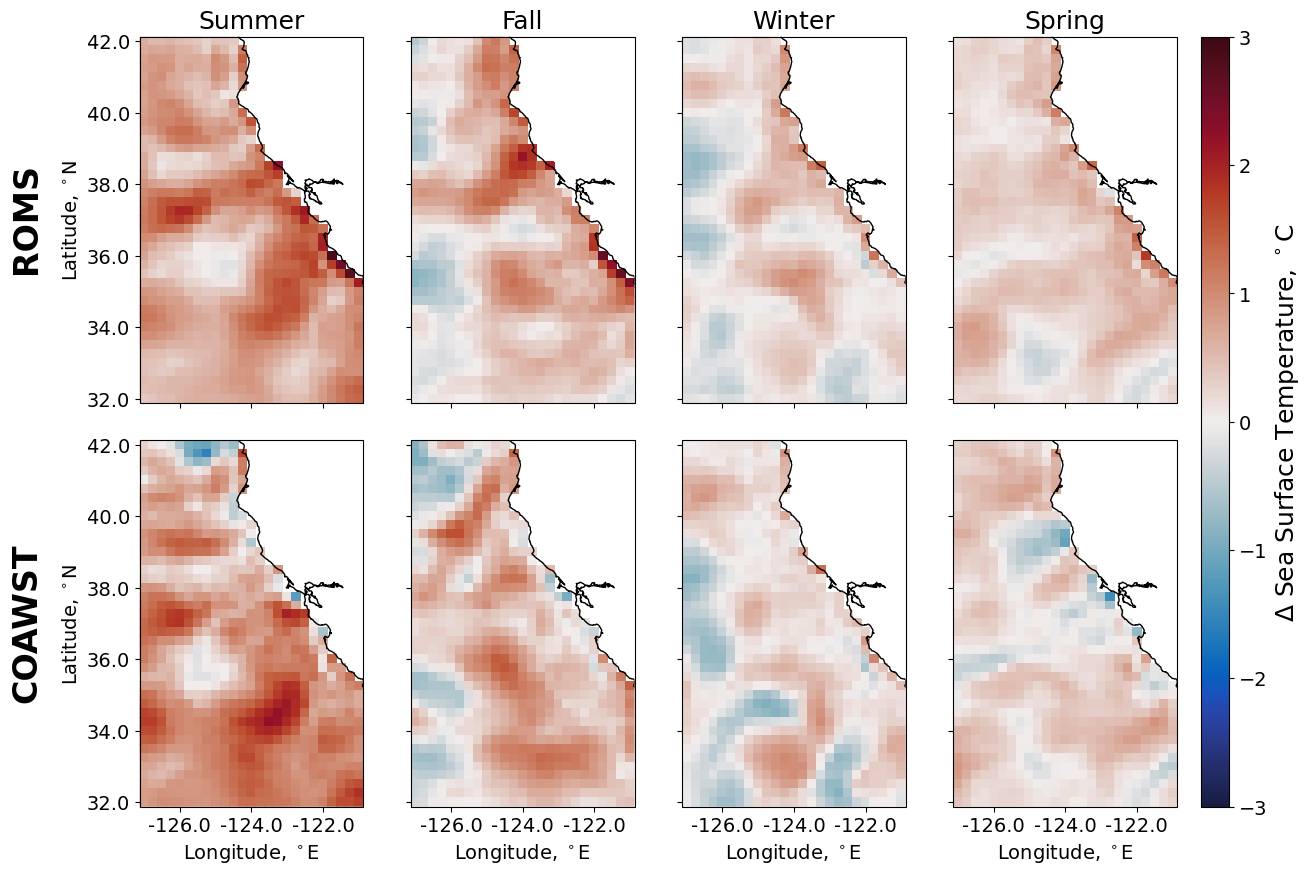

In [32]:

proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(14,10))
gs = gridspec.GridSpec(2, 4, width_ratios=[1, 1, 1, 1], hspace=0.1, wspace=0)

for axi in range(8):
    # ROMS plot first
    mgrab = rcmaps[axi]
    ax = plt.subplot(gs[axi], projection=proj)

    pc = ax.pcolor(longrab,latgrab,mgrab, cmap=cmo.balance,
                          vmin=-3, vmax=3)

    ax.coastlines()
    ax.set_xticks(lonticks)
    if axi<4:
        ax.set_title(szn_lab[axi], fontsize=18)
        ax.set_xlabel('')
        ax.xaxis.set_ticklabels([])
    # if xvec[axi]==3:
    else:
        ax.set_xlabel('Longitude, $^\circ$E', fontsize=14)
        ax.xaxis.set_ticklabels(lonticks, fontsize=14)
        
    ax.set_yticks(latticks)
    if axi%4==0:
        ax.set_ylabel('Latitude, $^\circ$N', fontsize=14)
        ax.yaxis.set_ticklabels(latticks, fontsize=14)
        if axi==0:
            ax.text(-130.75, 35.7, 'ROMS', fontsize=24, fontweight='demibold', rotation=90)
        elif axi==4:
            ax.text(-130.75, 35, 'COAWST', fontsize=24, fontweight='demibold', rotation=90)
    else:
        ax.set_ylabel('')
        ax.yaxis.set_ticklabels([])


cax = fig.add_axes([0.9, 0.11, 0.02, 0.77])
cbar = plt.colorbar(pc, cax=cax, aspect=0.2)
cbar.ax.set_ylabel('$\Delta$ Sea Surface Temperature, $^\circ$C', fontsize=18)
cbar.ax.tick_params(labelsize=14)
plt.show()


## Make combined figure

In [33]:
latticks = np.array([42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32])
latticks = latticks[1::2]
lonticks = np.array([-126, -124, -122])

In [34]:
ts_ylab = np.array([11,12,13,14,15,16,17,18,19])
ts_ylab

array([11, 12, 13, 14, 15, 16, 17, 18, 19])

In [36]:
sublab = ['(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)']

/tmp/ipykernel_193299/3011407530.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ts_ylab,fontsize=12)


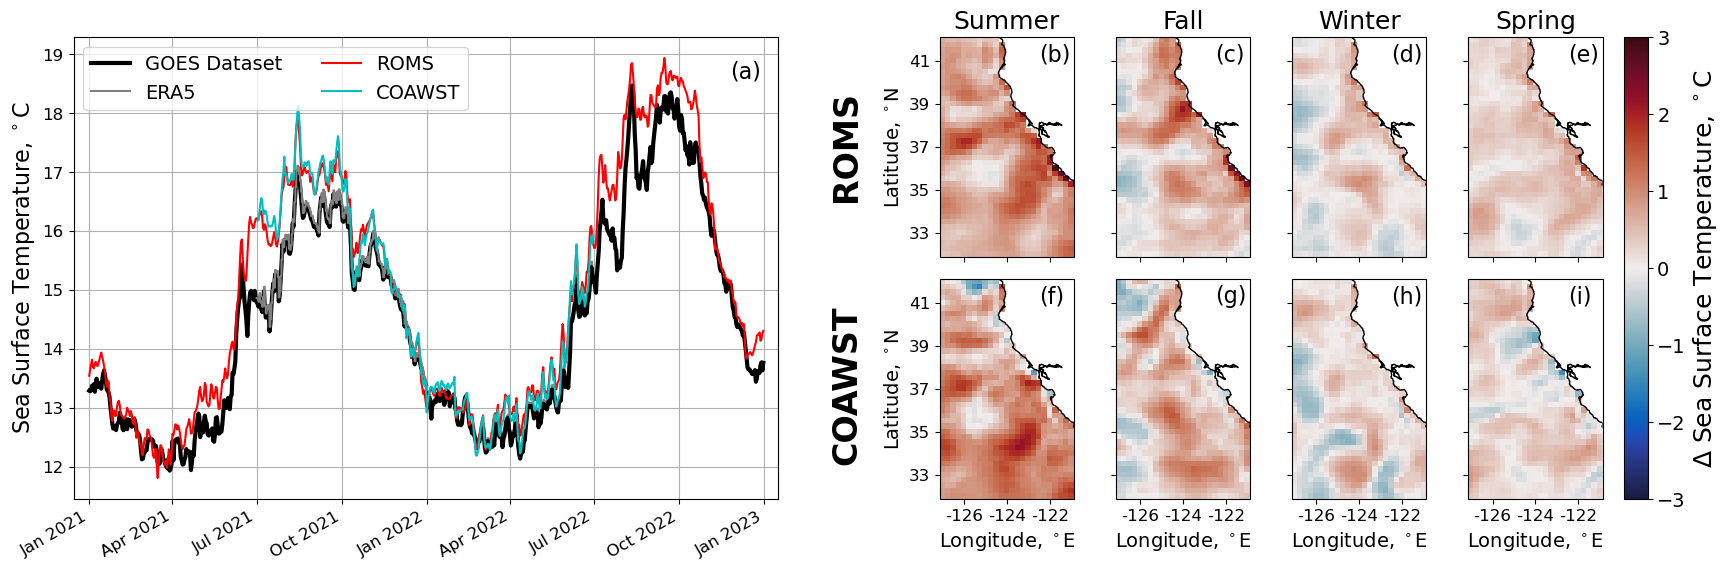

In [38]:
fig = plt.figure(figsize=(20, 6))

# fig = plt.figure()

gs0 = gridspec.GridSpec(1, 2, figure=fig)

gs00 = gridspec.GridSpecFromSubplotSpec(1,1, subplot_spec=gs0[0])

ax = plt.subplot(gs00[0, 0])

ax.plot(sat_21staxi, sat_21stser, color='k', label='GOES Dataset', linewidth=3)
ax.plot(era5_taxi, era5_sst, color='grey', label='ERA5')
ax.plot(sat_21staxi, roms_21mtser, color='r', label='ROMS')
ax.plot(sat_22staxi, sat_22stser, color='k',linewidth=3)
ax.plot(sat_22staxi, roms_22mtser, color='r')
ax.plot(cwst_mtaxi, cwst_mtser, color='c', label='COAWST')


# Set major ticks to be at the start of each month
ax.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

# Format major tick labels to show month and year
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right', fontsize=12)
# Optional: set minor ticks for days
ax.grid()
ax.set_xlim([mtaxi[0]+ddel, mtaxi[-1]-ddel])
ax.legend(fontsize=14, ncols=2)
ax.set_ylabel('Sea Surface Temperature, $^\circ$C', fontsize=16)
ax.set_yticklabels(ts_ylab,fontsize=12)
ax.text([mtaxi[-3]-datetime.timedelta(days=5)], 18.6, '(a)', fontsize=16)

#---------------------------------------------------------------------#
### COAWST Plot
gs01 = gridspec.GridSpecFromSubplotSpec(2, 4, subplot_spec=gs0[1], width_ratios=[1, 1, 1, 1], wspace=0, hspace=0.1)
#---------------------------------------------------------------------#

for axi in range(8):
    # ROMS plot first
    mgrab = rcmaps[axi]
    ax = plt.subplot(gs01[axi], projection=proj)

    pc = ax.pcolor(longrab,latgrab,mgrab, cmap=cmo.balance,
                          vmin=-3, vmax=3)

    ax.coastlines()
    ax.set_xticks(lonticks)
    if axi<4:
        ax.set_title(szn_lab[axi], fontsize=18)
        ax.set_xlabel('')
        ax.xaxis.set_ticklabels([])
    else:
        ax.set_xlabel('Longitude, $^\circ$E', fontsize=14)
        ax.xaxis.set_ticklabels(lonticks, fontsize=12)
        
    ax.text(-122.5, 41, sublab[axi], fontsize=16)
        
    ax.set_yticks(latticks)
    if axi%4==0:
        ax.set_ylabel('Latitude, $^\circ$N', fontsize=14)
        ax.yaxis.set_ticklabels(latticks, fontsize=12)
        if axi==0:
            ax.text(-132.25, 34.8, 'ROMS', fontsize=24, fontweight='demibold', rotation=90)
        elif axi==4:
            ax.text(-132.25, 33.8, 'COAWST', fontsize=24, fontweight='demibold', rotation=90)
    else:
        ax.set_ylabel('')
        ax.yaxis.set_ticklabels([])


cax = fig.add_axes([0.9, 0.11, 0.012, 0.77])
cbar = plt.colorbar(pc, cax=cax, aspect=0.2)
cbar.ax.set_ylabel('$\Delta$ Sea Surface Temperature, $^\circ$C', fontsize=18)
cbar.ax.tick_params(labelsize=14)
plt.show()

fig.savefig('Figure_4.png', format='png', dpi=300)